<a href="https://colab.research.google.com/github/naoya1110/DL_Lecture_202107/blob/main/Chapter13_Object_Detection_with_YOLOv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 13: Object Detection with YOLO
有名な物体検出モデルのYOLOを使ってみましょう。

参考：https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial

## 準備

### YOLO(Darknet)v4のダウンロードとインストール

In [1]:
! git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15185, done.
remote: Total 15185 (delta 0), reused 0 (delta 0), pack-reused 15185
Receiving objects: 100% (15185/15185), 13.59 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (10310/10310), done.


In [2]:
%cd darknet
! sed -i 's/OPENCV=0/OPENCV=1/' Makefile
! sed -i 's/GPU=0/GPU=1/' Makefile
! sed -i 's/CUDNN=0/CUDNN=1/' Makefile
! sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
! sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
! make

In [4]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2021-07-01 08:44:30--  https://docs.google.com/uc?export=download&confirm=ubns&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 142.251.2.113, 142.251.2.138, 142.251.2.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-3s-docs.googleusercontent.com/docs/securesc/afgm7korkqsie01k5qpa88qch5p6kade/ji6sqh3a9ethektinagvg59h87s0tsfk/1625129025000/17800843676226924807/08649018514774425380Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2021-07-01 08:44:31--  https://doc-0k-3s-docs.googleusercontent.com/docs/securesc/afgm7korkqsie01k5qpa88qch5p6kade/ji6sqh3a9ethektinagvg59h87s0tsfk/1625129025000/17800843676226924807/08649018514774425380Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-0k-3s-docs.googleusercontent.com (doc-0k-3s-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to

### 必要なパッケージのインポート

In [19]:
import os
import cv2
import matplotlib.pyplot as plt
import darknet

### 学習済みモデルの読み込み

In [6]:
# load in our YOLOv4 architecture network
network, class_names, class_colors = darknet.load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = darknet.network_width(network)
height = darknet.network_height(network)

### 物体検出を行う関数`darknet_helper()`を定義

In [7]:
# darknet helper function to run detection on image
def darknet_helper(img, width, height):
    darknet_image = darknet.make_image(width, height, 3)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (width, height), interpolation=cv2.INTER_LINEAR)

    # get image ratios to convert bounding boxes to proper size
    img_height, img_width, _ = img.shape
    width_ratio = img_width/width
    height_ratio = img_height/height

    # run model on darknet style image to get detections
    darknet.copy_image_from_bytes(darknet_image, img_resized.tobytes())
    detections = darknet.detect_image(network, class_names, darknet_image)
    darknet.free_image(darknet_image)

    return detections, width_ratio, height_ratio

## 動作確認

### サンプル画像に対して物体検出を実行

label=dog, conf=91.3%, (left, top, right, bottom)=(63, 265, 205, 345)
label=person, conf=93.0%, (left, top, right, bottom)=(190, 97, 277, 376)
label=horse, conf=93.0%, (left, top, right, bottom)=(406, 139, 602, 346)


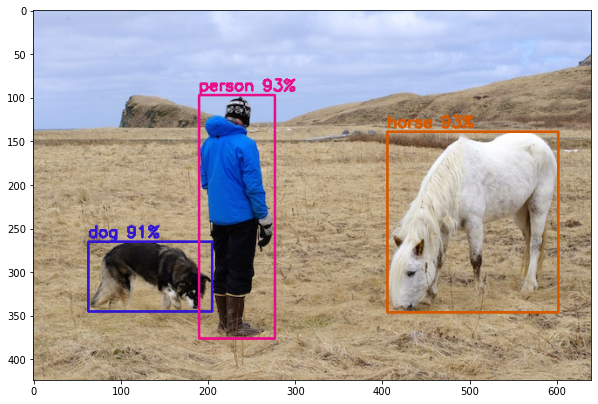

In [25]:
# run test on person.jpg image that comes with repository
img = cv2.imread("data/person.jpg")
detections, width_ratio, height_ratio = darknet_helper(img, width, height)

for label, confidence, bbox in detections:
    left, top, right, bottom = darknet.bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    print(f"label={label}, conf={float(confidence):.1f}%, (left, top, right, bottom)=({left}, {top}, {right}, {bottom})")
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, f"{label} {float(confidence):.0f}%", (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, class_colors[label], 2)

plt.figure(figsize=(10, 8))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## 独自の画像データに対して物体検出

### Googleドライブのマウント

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
working_dir = "/content/drive/MyDrive/DL_Lecture_202107"

### 画像データのパスを指定

In [27]:
filename = "cat.jpg"
img_path = os.path.join(working_dir, filename)
os.path.exists(img_path)

True

### 物体検出を実行

label=bench, conf=78.6%, (left, top, right, bottom)=(-2, 12, 643, 498)
label=cat, conf=85.0%, (left, top, right, bottom)=(119, 94, 648, 353)


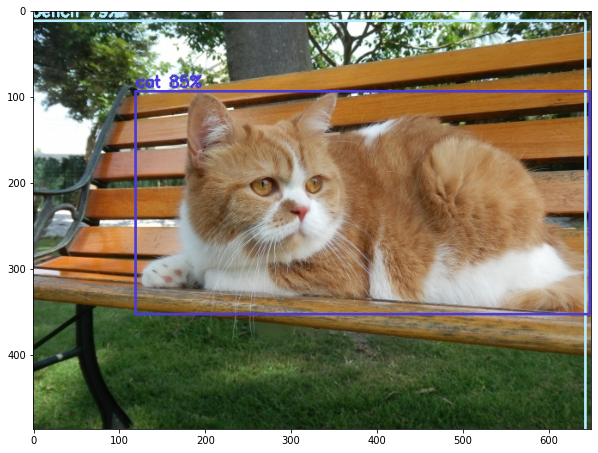

In [31]:
img = cv2.imread(img_path)
detections, width_ratio, height_ratio = darknet_helper(img, width, height)

for label, confidence, bbox in detections:
    left, top, right, bottom = darknet.bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    print(f"label={label}, conf={float(confidence):.1f}%, (left, top, right, bottom)=({left}, {top}, {right}, {bottom})")
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, f"{label} {float(confidence):.0f}%", (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, class_colors[label], 2)

plt.figure(figsize=(10, 8))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)